# Introduction

時系列データの異常検知を行います。

時系列データの異常検知の手法はこちらのスライドに記載しました。

今回はもっともシンプルなARモデルによる異常検知を行います。


# 各種ライブラリの取得



In [79]:
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html

In [7]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

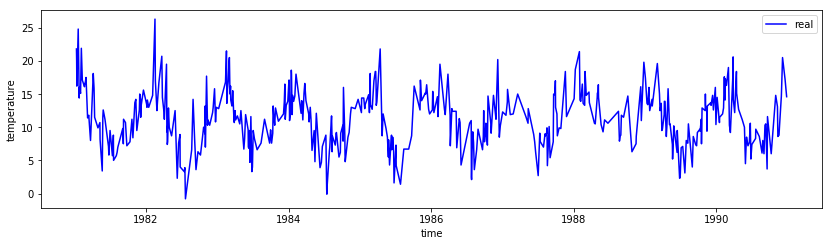

In [8]:
X_orig = wave_data["Temp"].values
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

# データの分割

- 学習データ
- 検証データ
- テストデータ

In [42]:
print(X_orig.shape)
X_train = X_orig[:300]
X_valid = X_orig[300:350]
X_test = X_orig[350:]

X_train_day = X_day[:300]
X_valid_day = X_day[300:350]
X_test_day = X_day[350:]

(500,)


# 学習データ

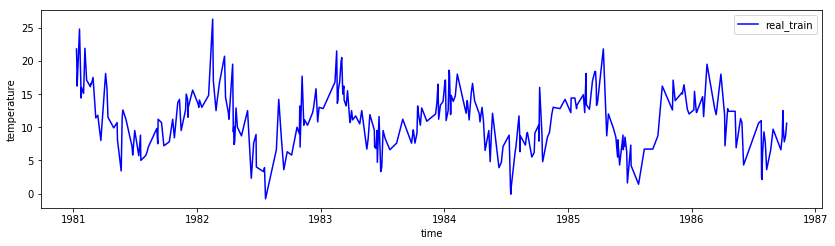

In [43]:
show_graph(X_train_day, X_train, 'real_train')

# 検証データ

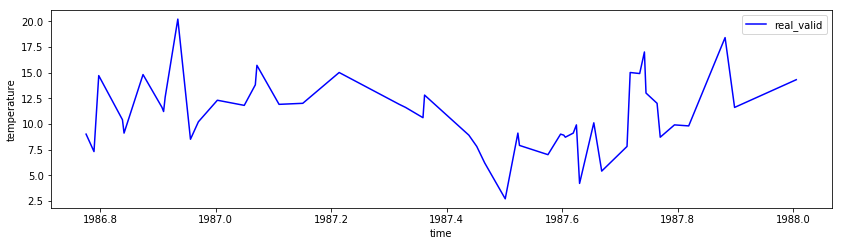

In [44]:
show_graph(X_valid_day, X_valid, 'real_valid')

# テストデータ

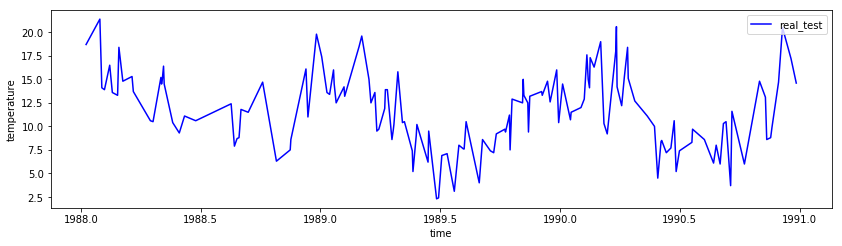

In [45]:
show_graph(X_test_day, X_test, 'real_test')

# Smooth process

- 移動平均によりスムージングして余分なノイズを除いています。下記の操作によってノイズを除去しています
 - 畳み込み処理

簡単な例を載せておきます。

In [46]:
window_len = 3
x = np.array([1, 2, 3, 4, 5])
w = np.ones(window_len, 'd')
print('window {}'.format(w))
    
y = np.convolve( w / w.sum(), x, mode='valid')
y

window [1. 1. 1.]


array([2., 3., 4.])

In [47]:
def smooth(x, window_len=11):

    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), x, mode='valid')
    return y

# 学習データのスムージング

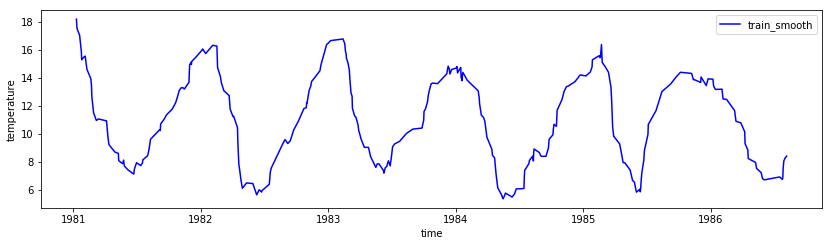

In [48]:
X_smooth_train = smooth(X_train)
X_train_day_smooth = X_train_day[:X_smooth_train.shape[0]]

show_graph(X_train_day_smooth, X_smooth_train, 'train_smooth')

# 検証データのスムージング

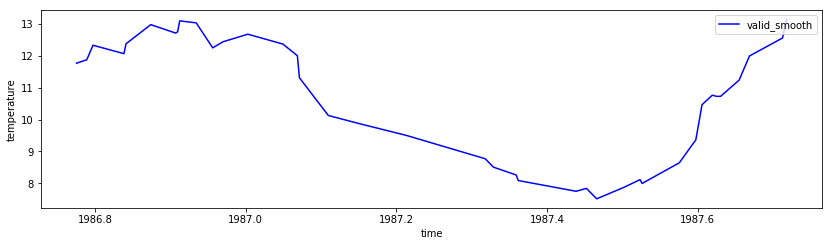

In [49]:
X_smooth_valid = smooth(X_valid)
X_valid_day_smooth = X_valid_day[:X_smooth_valid.shape[0]]

show_graph(X_valid_day_smooth, X_smooth_valid, 'valid_smooth')

# テストデータのスムージング

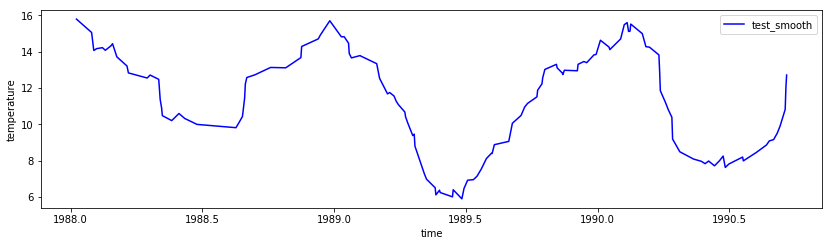

In [50]:
X_smooth_test = smooth(X_test)
X_test_day_smooth = X_test_day[:X_smooth_test.shape[0]]

show_graph(X_test_day_smooth, X_smooth_test, 'test_smooth')

# ARモデルの学習

- Lag: windowの幅
- Coefficients: 学習後のパラメータ

# 時間依存性について
- 時間差を考慮した自分自身との相関関係を自己相関と呼ぶ
- 自分との時間差をラグと呼ぶ

No handles with labels found to put in legend.


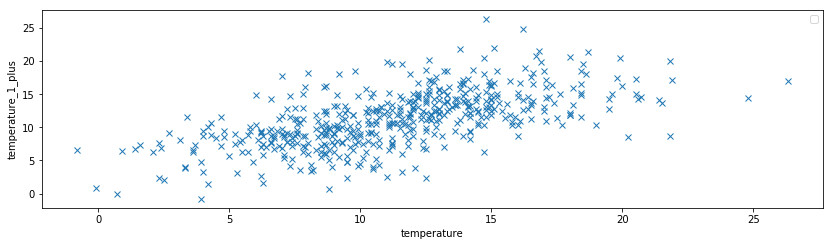

In [74]:
i = 1
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('temperature')
pylab.ylabel('temperature_' + str(i) + '_plus')
pylab.plot(X_orig[:-i], X_orig[i:], 'x')
pylab.legend(loc='upper right')
pylab.show()

ラグとの相関関係を表しています。95%信頼区間を水色で示しており、ラグが大きいほど相関が減っていくことが確認できます。

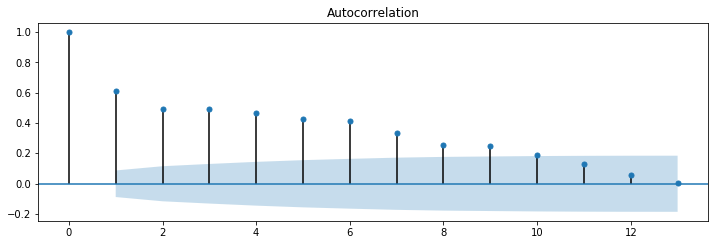

In [87]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_orig, lags=13, ax=ax1)

# 自己共分散

No handles with labels found to put in legend.


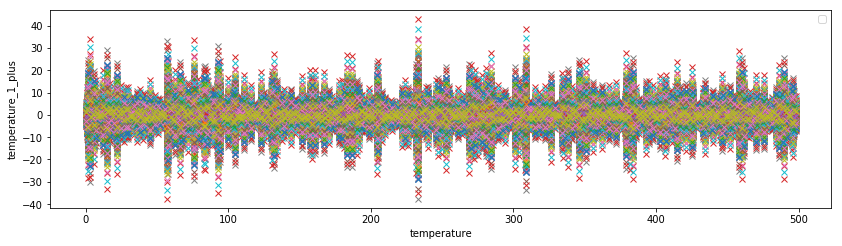

(499, 499)

In [91]:
a = np.array([X_orig[:-i], X_orig[i:]])
a_cov = np.cov(a, rowvar=0, bias=1)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('temperature')
pylab.ylabel('temperature_' + str(i) + '_plus')
pylab.plot(a_cov, 'x')
pylab.legend(loc='upper right')
pylab.show()
a_cov.shape

In [55]:
def train_autoregression(train_data):
    # train autoregression
    model = AR(train_data)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    print('aic {}'.format(model_fit.aic))
    return model_fit

# データの予測

- history: 過去データを保存し予測に使用
- lag: 過去データの末尾のwindowサイズ分のデータを保持
- yhat: ARモデルの予測データ

In [56]:
def predict_autoregression(model, valid_data):
    window = model.k_ar
    coef = model.params
    
    # windowサイズ分、データの末尾を取得
    history = valid_data[len(valid_data) - window:]
    history = valid_data[:window]
    history = [h for h in history]
    predictions = []

    for index, test in enumerate(valid_data):
        # 過去のデータサイズを取得
        length = len(history)
        # windowサイズ分、観測したデータを追加していく
        lag = [history[i] for i in range(length - window, length)]
        yhat = coef[0]
        for d in range(window):
            # 実測値とパラメータをかけて予測値を導出
            yhat += coef[d + 1] * lag[window - d - 1]
        obs = test
        predictions.append(yhat)
        history.append(obs)

    return predictions

予測は最初のwindow幅分は上手く動作しない。過去の自分の値を用いるため、最初のwindow分の値のズレが大きいと予測ができない

Lag: 16
Coefficients: [ 0.83381629  1.25428311 -0.24407503  0.12534276 -0.04324986 -0.05128195
  0.04569956 -0.22667238  0.05549717  0.1230015  -0.03594741 -0.45135512
  0.56512759 -0.08477151 -0.05925277  0.00866351 -0.05619736]
aic -2.2205263349638367


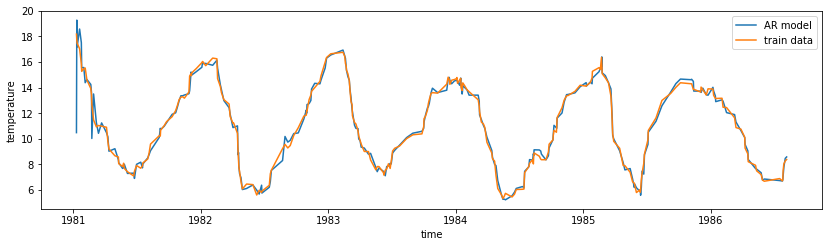

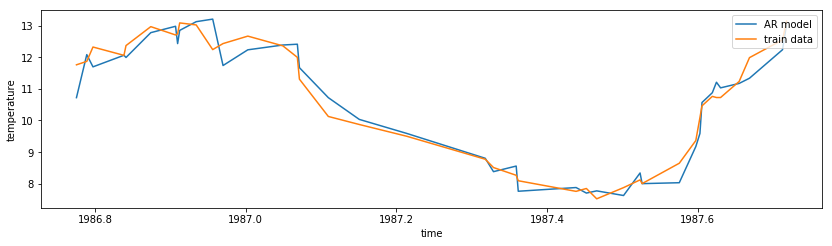

In [57]:
model = train_autoregression(X_smooth_train)

X_smooth_train = X_smooth_train
predictions = predict_autoregression(model, X_smooth_train)

X_smooth_valid = X_smooth_valid
predictions_valid = predict_autoregression(model, X_smooth_valid)

show_2data_graph(X_train_day_smooth, predictions, X_smooth_train, 'AR model', 'train data')

show_2data_graph(X_valid_day_smooth, predictions_valid, X_smooth_valid, 'AR model', 'valid data')

# Smoothなしで学習

ARモデルでは上手く模倣できない。
データが安定しておらず線形結合による模倣が難しいため

Lag: 16
Coefficients: [ 4.37285592e+00  3.25969155e-01 -1.26287279e-02  2.03435257e-01
  1.46624126e-01  1.00379028e-01  1.24653027e-01 -4.86291431e-02
 -4.29029929e-02  8.15134790e-02 -2.26127786e-03  6.17743355e-02
 -5.95052681e-02  2.76461595e-03 -1.46707291e-01 -8.10205319e-02
 -4.63680997e-02]
aic 2.3113410043514073


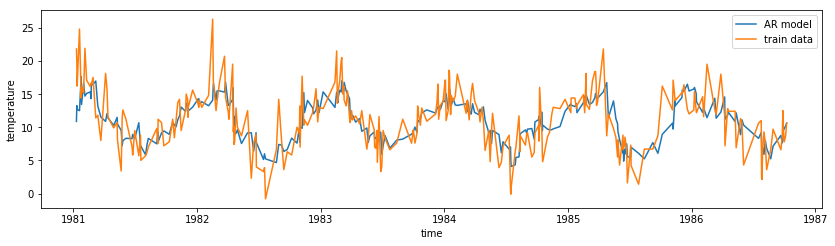

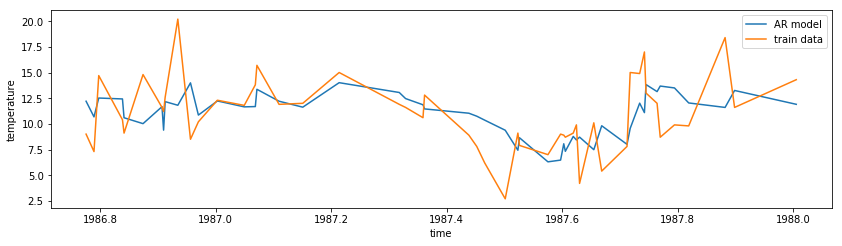

In [58]:
model_non_smooth = train_autoregression(X_train)

predictions_non_smooth = predict_autoregression(model_non_smooth, X_train)

predictions_valid_non_smooth = predict_autoregression(model_non_smooth, X_valid)

show_2data_graph(X_train_day, predictions_non_smooth, X_train, 'AR model', 'train data')

show_2data_graph(X_valid_day, predictions_valid_non_smooth, X_valid, 'AR model', 'train data')

# 異常データの作成

本来は元データに異常を付与する必要があるが分かりづらいのでスムージングしたデータに異常を付与

- スパイク型
- 波形変化
- レベルシフト

# スパイク型

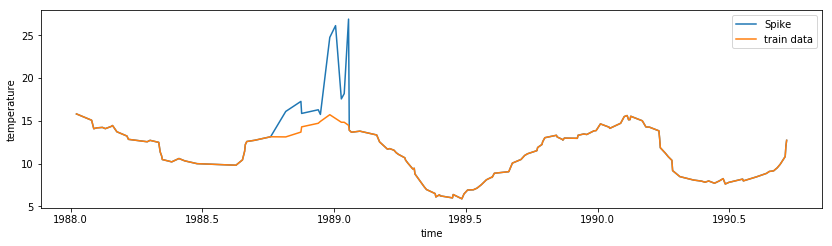

In [51]:
series = [np.abs(gauss(0.0, 7.0)) for i in range(10)]
spike_X = X_smooth_test.copy() 
spike_X[30:40] = spike_X[30:40] + series

def show_2data_graph(day, data, compare_data, label, compare_label):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, label=label)
    pylab.plot(day, compare_data, label='train data')
    pylab.legend(loc='upper right')
    pylab.show()

show_2data_graph(X_test_day_smooth, spike_X, X_smooth_test, 'Spike', 'test_smooth')

# 波形変化

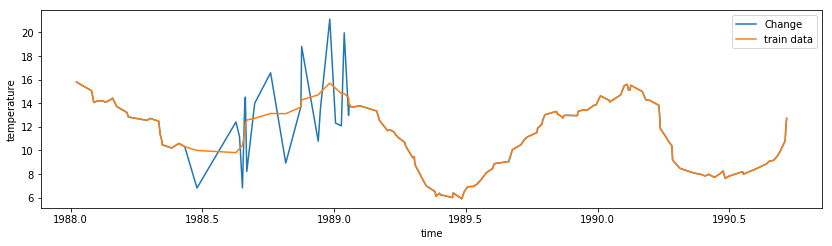

In [53]:
change_value = np.arange(0, 40, 2)
change_X = X_smooth_test.copy() 
change_X[20:40] = change_X[20:40] - (0.35 * change_X[20:40] * np.sin(change_value))

show_2data_graph(X_test_day_smooth, change_X, X_smooth_test, 'Change', 'test_smooth')

# レベルシフト

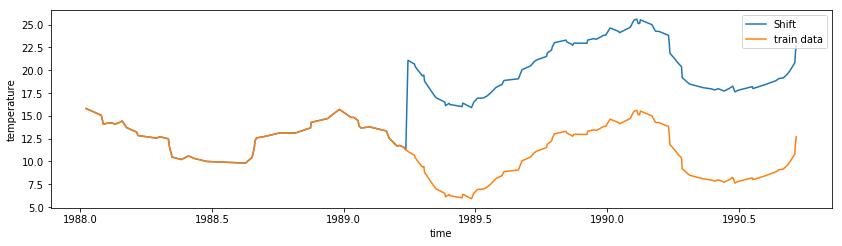

In [54]:
shift_X = X_smooth_test.copy() 
shift_X[50:] = shift_X[50:] + 10.0

show_2data_graph(X_test_day_smooth, shift_X, X_smooth_test, 'Shift', 'test_smooth')

# Anomaly Score

異常度の計算部分
- 初回の計算は分散が不定なので1で固定
- 学習データで導出した分散を使用

In [59]:
def calculate_mse(value, predict_value, variance=1.0):
    mse_value = [(v - p_v)**2 / variance for v, p_v in zip(value, predict_value)]
    return mse_value

window = model.k_ar
mse_value_org = calculate_mse(X_smooth_train[window:], predictions[window:])
mse_value_variance = np.mean(mse_value_org)

mse_value = calculate_mse(X_smooth_train[window:], predictions[window:], mse_value_variance)

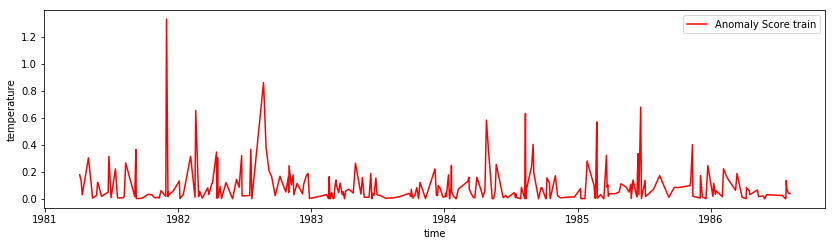

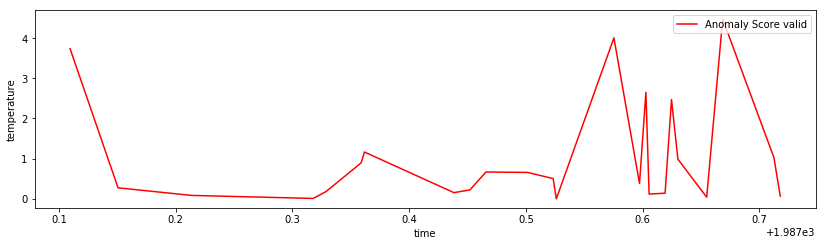

threshold value 4.468231558819185


In [60]:
show_graph(X_train_day_smooth[window:], mse_value_org, 'Anomaly Score train', color="r")

mse_value_valid = calculate_mse(X_smooth_valid[window:], predictions_valid[window:], mse_value_variance)

show_graph(X_valid_day_smooth[window:], mse_value_valid, 'Anomaly Score valid', color="r")

threshold = np.max(mse_value_valid)
print("threshold value {}".format(threshold))

# Anomaly Detection

# Non Smooth Normal Data Case

スムージングしないと正常データでも異常と判断してしまう

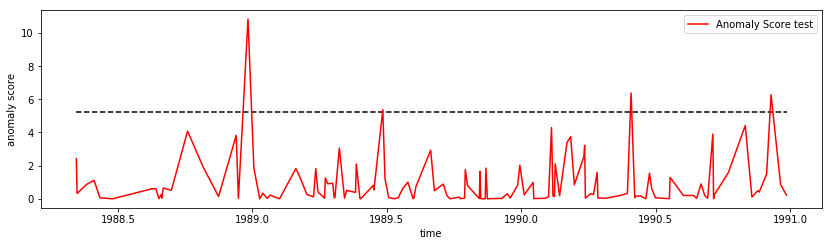

In [61]:
mse_value_org = calculate_mse(X_train[window:], predictions_non_smooth[window:])
mse_value_variance = np.mean(mse_value_org)
mse_value = calculate_mse(X_train[window:], predictions_non_smooth[window:], mse_value_variance)

mse_value_valid = calculate_mse(X_valid[window:], predictions_valid_non_smooth[window:], mse_value_variance)
threshold_non_smooth = np.max(mse_value_valid)

predictions_test_non_smooth = predict_autoregression(model_non_smooth, X_test)

mse_value_test = calculate_mse(X_test[window:], predictions_test_non_smooth[window:], mse_value_variance)

def show_graph_threshold(day, data, threshold, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('anomaly score')
    pylab.plot(day, np.repeat(threshold, day.shape[0]), 'k-', color = "k", ls = "dashed")
    pylab.plot(day, data, "r", label='Anomaly Score test')
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph_threshold(X_test_day[window:], mse_value_test, threshold_non_smooth, 'Anomaly Score test', "r")

# Normal Data Case

正常データは異常として検知しないかを確認

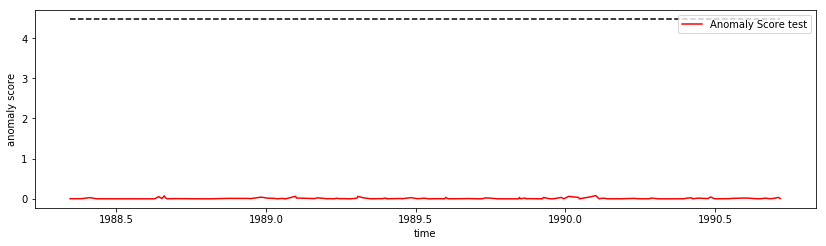

In [62]:
predictions_test = predict_autoregression(model, X_smooth_test)

mse_value_test_normal = calculate_mse(X_smooth_test[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_normal, threshold, 'Anomaly Score test', "r")

# Spike Wave Case

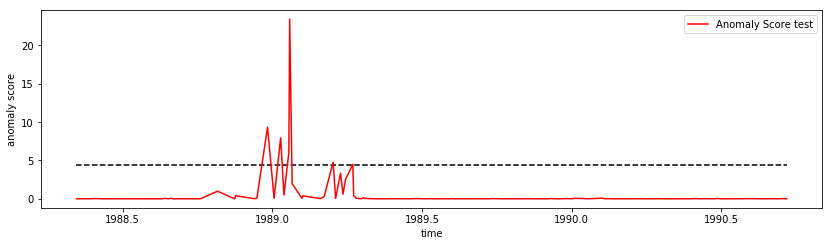

In [63]:
spike_X = spike_X
predictions_test = predict_autoregression(model, spike_X)

mse_value_test_spike = calculate_mse(spike_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_spike, threshold, 'Anomaly Score test Spike', "r")


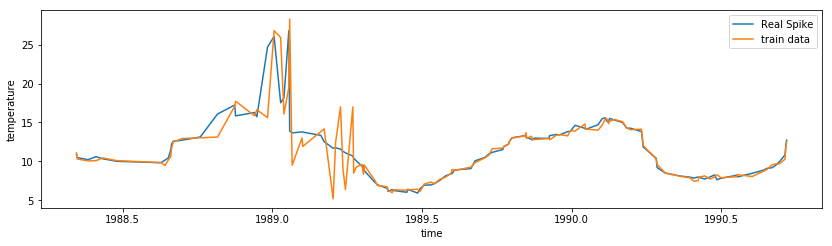

In [64]:
show_2data_graph(X_test_day_smooth[window:], spike_X[window:], predictions_test[window:], 
                 'Real Spike', 'Predict Spike')

# Change Wave Case

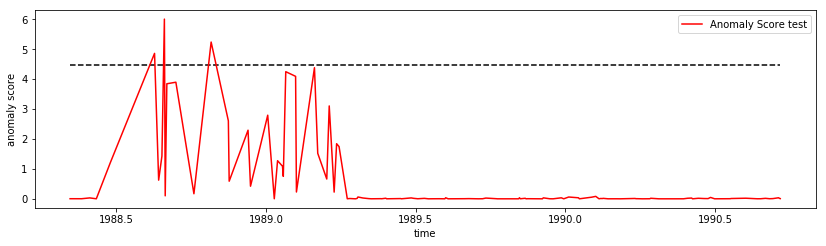

In [65]:
change_X = change_X
predictions_test = predict_autoregression(model, change_X)

mse_value_test_change_wave = calculate_mse(change_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_change_wave, threshold, 'Anomaly Score test change', "r")

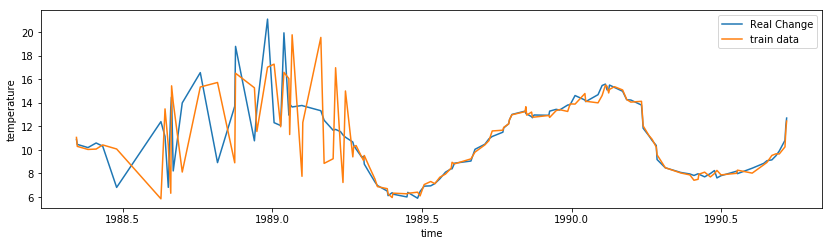

In [66]:
show_2data_graph(X_test_day_smooth[window:], change_X[window:], predictions_test[window:], 
                 'Real Change', 'Predict Change')

# Shift Wave Case

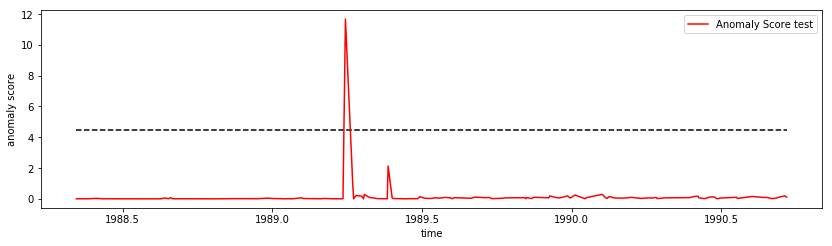

In [67]:
predictions_test = predict_autoregression(model, shift_X)

mse_value_test_shift = calculate_mse(shift_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_shift, threshold, 'Anomaly Score test shift', "r")

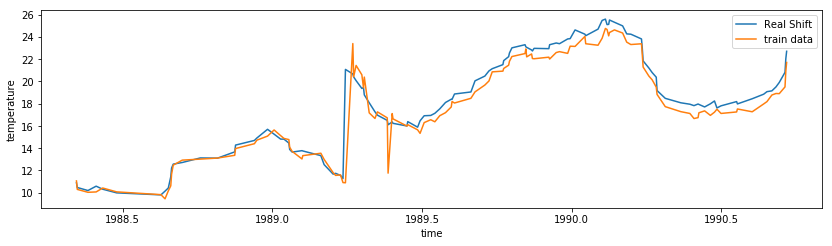

In [68]:
show_2data_graph(X_test_day_smooth[window:], shift_X[window:], predictions_test[window:], 
                 'Real Shift', 'Predict Shift')

# ROC カーブを記述し実際の性能を確認

- 異常の部分を0、正常部分を1の配列を用意
- rocに渡すスコアの引数は正常である確信度なので異常度の場合は逆数にする必要がある

(124,)


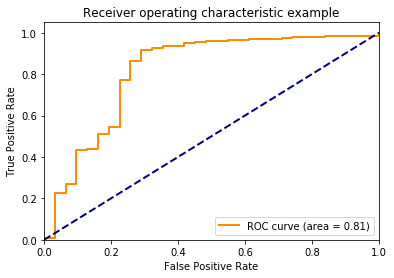

In [69]:
mse_value_test_normal = np.array(mse_value_test_normal)
mse_value_test_spike = np.array(mse_value_test_spike)
mse_value_test_change_wave = np.array(mse_value_test_change_wave)
mse_value_test_shift = np.array(mse_value_test_shift)

# Normal
answer_normal = np.ones(X_smooth_test[window:].shape)

# Spike
answer_spike = np.ones(spike_X[window:].shape)
answer_spike[30:40] = 0

# Change
answer_change = np.ones(change_X[window:].shape)
answer_change[20:40] = 0

# Shift
print(shift_X[window:].shape)
answer_shift = np.ones(shift_X[window:].shape)
answer_shift[50] = 0

anomaly_score = np.append(mse_value_test_normal, 
                          mse_value_test_spike)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_change_wave)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_shift,
                         )

answer_array = np.append(answer_normal, answer_spike)
answer_array = np.append(answer_array, answer_change)
answer_array = np.append(answer_array, answer_shift)

fpr, tpr, _ = roc_curve(answer_array, 1.0 / anomaly_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 発展課題
- 異常データを作成して検知できるか試して見ましょう
 - 非周期型はまだやっていないです
- ROCの性能が不十分なので上げるための方法を考えてみましょう